##範例二: Normal and Shrinkage Linear Discriminant Analysis for classification
http://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html


Python source code: [plot_lda.py](http://scikit-learn.org/stable/_downloads/plot_lda.py)
```python
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


n_train = 20  # samples for training
n_test = 200  # samples for testing
n_averages = 50  # how often to repeat classification
n_features_max = 75  # maximum number of features
step = 4  # step size for the calculation


def generate_data(n_samples, n_features):
    """Generate random blob-ish data with noisy features.

    This returns an array of input data with shape `(n_samples, n_features)`
    and an array of `n_samples` target labels.

    Only one feature contains discriminative information, the other features
    contain only noise.
    """
    X, y = make_blobs(n_samples=n_samples, n_features=1, centers=[[-2], [2]])

    # add non-discriminative features
    if n_features > 1:
        X = np.hstack([X, np.random.randn(n_samples, n_features - 1)])
    return X, y

acc_clf1, acc_clf2 = [], []
n_features_range = range(1, n_features_max + 1, step)
for n_features in n_features_range:
    score_clf1, score_clf2 = 0, 0
    for _ in range(n_averages):
        X, y = generate_data(n_train, n_features)

        clf1 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto').fit(X, y)
        clf2 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=None).fit(X, y)

        X, y = generate_data(n_test, n_features)
        score_clf1 += clf1.score(X, y)
        score_clf2 += clf2.score(X, y)

    acc_clf1.append(score_clf1 / n_averages)
    acc_clf2.append(score_clf2 / n_averages)

features_samples_ratio = np.array(n_features_range) / n_train

plt.plot(features_samples_ratio, acc_clf1, linewidth=2,
         label="Linear Discriminant Analysis with shrinkage", color='r')
plt.plot(features_samples_ratio, acc_clf2, linewidth=2,
         label="Linear Discriminant Analysis", color='g')

plt.xlabel('n_features / n_samples')
plt.ylabel('Classification accuracy')

plt.legend(loc=1, prop={'size': 12})
plt.suptitle('Linear Discriminant Analysis vs. \
shrinkage Linear Discriminant Analysis (1 discriminative feature)')
plt.show()
```

這個範例用來展示scikit-learn 如何使用Linear Discriminant Analysis (LDA) 線性判別分析來達成資料分類的目的

1. 利用 `sklearn.datasets.make_blobs` 產生測試資料
2. 利用自定義函數 `generate_data` 產生具有數個特徵之資料集，其中僅有一個特徵對於資料分料判斷有意義
3. 使用`LinearDiscriminantAnalysis`來達成資料判別
4. 比較於LDA演算法中，開啟 `shrinkage` 前後之差異

## (一)產生測試資料
從程式碼來看，一開始主要為自定義函數`generate_data(n_samples, n_features)`，這個函數的主要目的為產生一組測試資料，總資料列數為`n_samples`，每一列共有`n_features`個特徵。而其中只有第一個特徵得以用來判定資料類別，其他特徵則毫無意義。`make_blobs`負責產生單一特徵之資料後，利用｀np.random.randn｀　亂數產生其他｀n_features - 1｀個特徵，之後利用`np.hstack`以"水平" (horizontal)方式連接X以及亂數產生之特徵資料。

In [21]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

n_train = 20  # samples for training
n_test = 200  # samples for testing
n_averages = 50  # how often to repeat classification
n_features_max = 75  # maximum number of features
step = 4  # step size for the calculation

def generate_data(n_samples, n_features):
    X, y = make_blobs(n_samples=n_samples, n_features=1, centers=[[-2], [2]])
    # add non-discriminative features
    if n_features > 1:
        X = np.hstack([X, np.random.randn(n_samples, n_features - 1)])
    return X, y


我們可以用以下的程式碼來測試自定義函式，結果回傳了X (10x5矩陣)及y(10個元素之向量)，我們可以使用`pandas.DataFrame`套件來觀察資料。我們可以看到只有X的第一行特徵資料(X0) 與目標數值 y 有一個明確的對應關係，也就是y為1時，數值較大。

In [58]:
X, y = generate_data(10, 5)

import pandas as pd
pd.set_option('precision',2)
df=pd.DataFrame(np.hstack([y.reshape(10,1),X]))
df.columns = ['y', 'X0', 'X1', 'X2', 'X2', 'X4']
print(df)

   y    X0    X1    X2    X2    X4
0  1  0.38  0.35  0.80 -0.97 -0.68
1  1  2.41  0.31 -1.47  0.10 -1.39
2  1  1.65 -0.99 -0.12 -0.38  0.18
3  0 -4.86  0.14 -0.80  1.13 -1.31
4  1 -0.06 -1.99 -0.70 -1.26 -1.64
5  0 -1.51 -1.74 -0.83  0.74 -2.07
6  0 -2.50  0.44 -0.45 -0.55 -0.42
7  1  1.55  1.38  0.93 -1.44  0.27
8  0 -1.95  0.32 -0.28  0.02  0.07
9  0 -0.58 -0.07 -1.01  0.15 -1.84


## (二)改變特徵數量並測試shrinkage之功能

接下來程式碼裏有兩段迴圈，外圈改變特徵數量。內圈則多次嘗試LDA之以求精準度。使用`LinearDiscriminantAnalysis`來訓練分類器，過程中以`shrinkage='auto'`以及`shrinkage=None`來控制shrinkage之開關，將分類器分別以`clf1`以及`clf2`儲存。之後再產生新的測試資料將準確度加入`score_clf1`及`score_clf2`裏，離開內迴圈之後除以總數以求平均。

In [ ]:
acc_clf1, acc_clf2 = [], []
n_features_range = range(1, n_features_max + 1, step)
for n_features in n_features_range:
    score_clf1, score_clf2 = 0, 0
    for _ in range(n_averages):
        X, y = generate_data(n_train, n_features)

        clf1 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto').fit(X, y)
        clf2 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=None).fit(X, y)

        X, y = generate_data(n_test, n_features)
        score_clf1 += clf1.score(X, y)
        score_clf2 += clf2.score(X, y)

    acc_clf1.append(score_clf1 / n_averages)
    acc_clf2.append(score_clf2 / n_averages)

## (三)顯示LDA判別結果


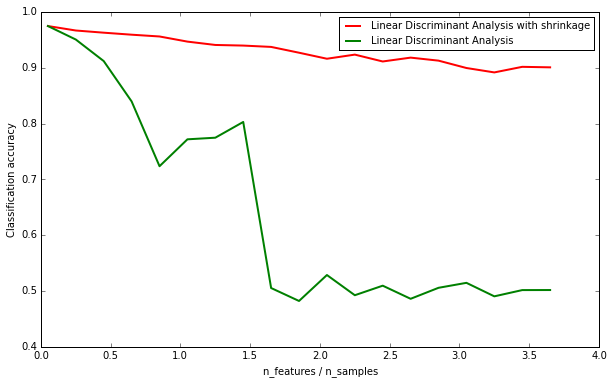

In [78]:
features_samples_ratio = np.array(n_features_range) / n_train
fig = plt.figure(figsize=(10,6), dpi=300)
plt.plot(features_samples_ratio, acc_clf1, linewidth=2,
         label="Linear Discriminant Analysis with shrinkage", color='r')
plt.plot(features_samples_ratio, acc_clf2, linewidth=2,
         label="Linear Discriminant Analysis", color='g')

plt.xlabel('n_features / n_samples')
plt.ylabel('Classification accuracy')

plt.legend(loc=1, prop={'size': 10})
#plt.suptitle('Linear Discriminant Analysis vs. \
#shrinkage Linear Discriminant Analysis (1 discriminative feature)')
plt.show()

In [ ]:
%matplotlib inline
from __future__ import division
'''
from __future__ import division

now:

1 / 2 --> 0.5
4 / 2 --> 2.0
1 // 2 --> 0
4 // 2 --> 2
'''
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


n_train = 20  # samples for training
n_test = 200  # samples for testing
n_averages = 50  # how often to repeat classification
n_features_max = 75  # maximum number of features
step = 4  # step size for the calculation


def generate_data(n_samples, n_features):
    """Generate random blob-ish data with noisy features.

    This returns an array of input data with shape `(n_samples, n_features)`
    and an array of `n_samples` target labels.

    Only one feature contains discriminative information, the other features
    contain only noise.
    """
    X, y = make_blobs(n_samples=n_samples, n_features=1, centers=[[-2], [2]])

    # add non-discriminative features
    if n_features > 1:
        X = np.hstack([X, np.random.randn(n_samples, n_features - 1)])
    return X, y

acc_clf1, acc_clf2 = [], []
n_features_range = range(1, n_features_max + 1, step)
for n_features in n_features_range:
    score_clf1, score_clf2 = 0, 0
    for _ in range(n_averages):
        X, y = generate_data(n_train, n_features)

        clf1 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto').fit(X, y)
        clf2 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=None).fit(X, y)

        X, y = generate_data(n_test, n_features)
        score_clf1 += clf1.score(X, y)
        score_clf2 += clf2.score(X, y)

    acc_clf1.append(score_clf1 / n_averages)
    acc_clf2.append(score_clf2 / n_averages)

features_samples_ratio = np.array(n_features_range) / n_train

plt.plot(features_samples_ratio, acc_clf1, linewidth=2,
         label="Linear Discriminant Analysis with shrinkage", color='r')
plt.plot(features_samples_ratio, acc_clf2, linewidth=2,
         label="Linear Discriminant Analysis", color='g')

plt.xlabel('n_features / n_samples')
plt.ylabel('Classification accuracy')

plt.legend(loc=1, prop={'size': 12})
plt.suptitle('Linear Discriminant Analysis vs. \
shrinkage Linear Discriminant Analysis (1 discriminative feature)')
plt.show()